In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random

In [2]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
transform =transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = torch.tensor(x_train).unsqueeze(1)
x_test  = torch.tensor(x_test).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

print(x_train.shape, y_train.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000])


In [6]:
train_ds = TensorDataset(x_train, y_train)
test_ds  = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

In [7]:
def add_patchy_noise(batch, gamma=0.5, patch_size=8):

    noisy_batch = batch.clone()
    B, C, H, W = batch.shape
    device = batch.device

    for i in range(B):
        r = torch.randint(0, H - patch_size, (1,)).item()
        c = torch.randint(0, W - patch_size, (1,)).item()
        noise = gamma * torch.randn((C, patch_size, patch_size), device=device)  # <-- FIXED
        noisy_batch[i, :, r:r+patch_size, c:c+patch_size] += noise

    noisy_batch = torch.clamp(noisy_batch, 0., 1.)
    return noisy_batch

In [8]:

class DAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim1=512, hidden_dim2=256, latent_dim=128):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, latent_dim)

        self.fc4 = nn.Linear(latent_dim, hidden_dim2)
        self.fc5 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc6 = nn.Linear(hidden_dim1, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        return h3

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        h6 = self.sigmoid(self.fc6(h5))
        return h6

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encode(x)
        y = self.decode(z)
        return y.view(-1, 1, 28, 28)

In [14]:
model= DAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 15

In [15]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for xb, _ in train_loader:
        xb = xb.to(device)

        xb_noisy = add_patchy_noise(xb, gamma=0.5).to(device)

        out = model(xb_noisy)
        loss = criterion(out, xb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss={epoch_loss/len(train_loader):.4f}")


Epoch 1/15, Loss=0.0496
Epoch 2/15, Loss=0.0240
Epoch 3/15, Loss=0.0187
Epoch 4/15, Loss=0.0153
Epoch 5/15, Loss=0.0133
Epoch 6/15, Loss=0.0120
Epoch 7/15, Loss=0.0111
Epoch 8/15, Loss=0.0104
Epoch 9/15, Loss=0.0098
Epoch 10/15, Loss=0.0093
Epoch 11/15, Loss=0.0089
Epoch 12/15, Loss=0.0086
Epoch 13/15, Loss=0.0083
Epoch 14/15, Loss=0.0081
Epoch 15/15, Loss=0.0079


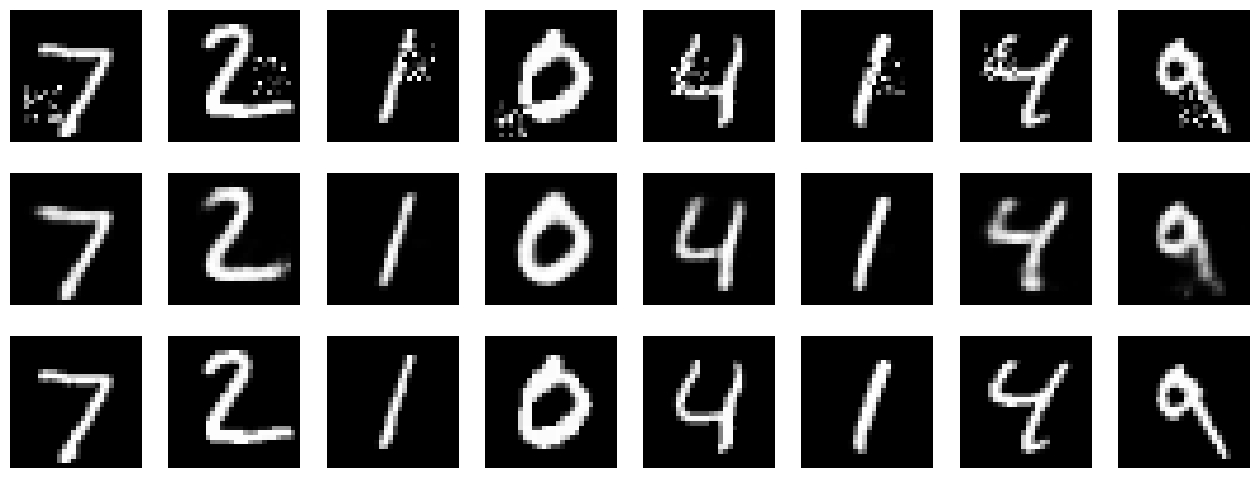

In [16]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    xb, _ = next(iter(test_loader))
    xb = xb.to(device)
    xb_noisy = add_patchy_noise(xb, gamma=0.5).to(device)
    out = model(xb_noisy)

n = 8
fig, axes = plt.subplots(3, n, figsize=(n*2, 6))
for i in range(n):
    axes[0, i].imshow(xb_noisy[i,0].cpu(), cmap="gray"); axes[0, i].axis("off")
    axes[1, i].imshow(out[i,0].cpu(), cmap="gray"); axes[1, i].axis("off")
    axes[2, i].imshow(xb[i,0].cpu(), cmap="gray"); axes[2, i].axis("off")

axes[0,0].set_ylabel("Noisy", fontsize=12)
axes[1,0].set_ylabel("Denoised", fontsize=12)
axes[2,0].set_ylabel("Clean", fontsize=12)
plt.show()


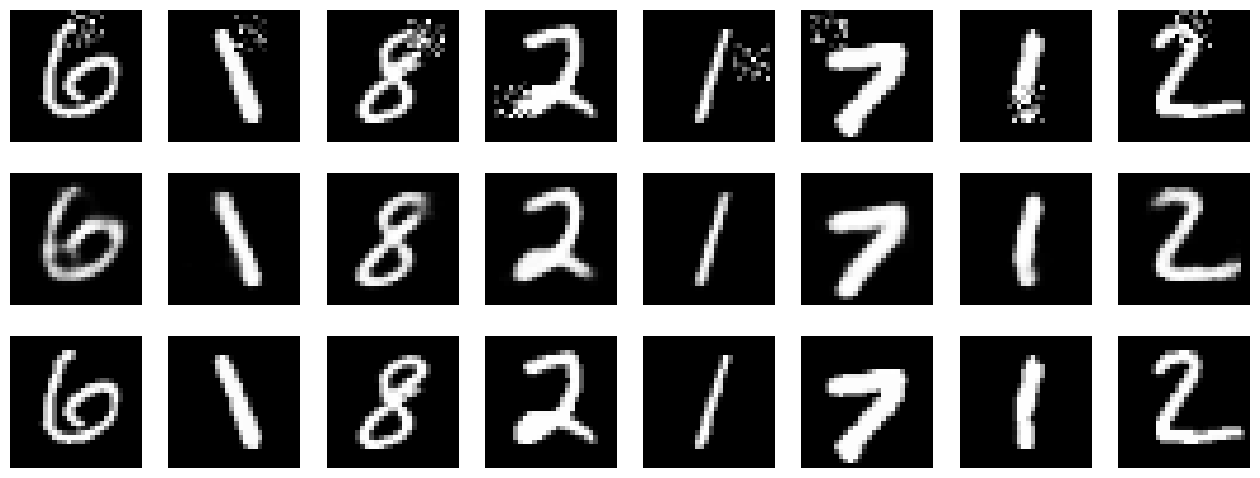

In [17]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    xb, _ = next(iter(test_loader))
    xb = xb.to(device)

    xb_noisy = add_patchy_noise(xb, gamma=0.5).to(device)

    out = model(xb_noisy)

n = 8
idxs = torch.randint(0, xb.shape[0], (n,))

fig, axes = plt.subplots(3, n, figsize=(n*2, 6))
for j, i in enumerate(idxs):
    axes[0, j].imshow(xb_noisy[i,0].cpu().squeeze(), cmap="gray")
    axes[0, j].axis("off")

    axes[1, j].imshow(out[i,0].cpu().squeeze(), cmap="gray")
    axes[1, j].axis("off")

    axes[2, j].imshow(xb[i,0].cpu().squeeze(), cmap="gray")
    axes[2, j].axis("off")

axes[0,0].set_ylabel("Noisy", fontsize=12)
axes[1,0].set_ylabel("Denoised", fontsize=12)
axes[2,0].set_ylabel("Clean", fontsize=12)
plt.show()
